In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.optim as optim
import os
import csv
import json
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from types import SimpleNamespace

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
from model import VisionGPT2Model

In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

'<|endoftext|>'

In [ ]:
gen_tfms = A.Compose([
            A.Resize(224,224),
            A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
            ToTensorV2()
        ])

model_config = SimpleNamespace(
    vocab_size = 50_257,
    embed_dim = 768,
    num_heads = 12,
    seq_len = 1024,
    depth = 12,
    attention_dropout = 0.1,
    residual_dropout = 0.1,
    mlp_ratio = 4,
    mlp_dropout = 0.1,
    emb_dropout = 0.1,
)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset"
BEST_MODEL = "trained_model_B.pth"
model = VisionGPT2Model(model_config)  # Make sure to provide the necessary configuration
model.load_state_dict(torch.load(os.path.join(MODEL_DIR,BEST_MODEL),map_location=device))  # Load model state dict from .pth file


<All keys matched successfully>

In [ ]:
model.to(device)
model.eval()

In [ ]:
# tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
# self.tokenizer.pad_token = self.tokenizer.eos_token
@torch.no_grad()
def generate_caption(image,temperature=1.0,deterministic=False):
  # self.model.eval()
  max_tokens=50
  image = Image.open(image).convert('RGB')
  image = np.array(image)
  image = gen_tfms(image=image)['image']
  image = image.unsqueeze(0).to(device)
  sequence = torch.ones(1,1).to(device).long() * tokenizer.bos_token_id

  caption = model.generate(
      image,
      sequence,
      max_tokens=max_tokens,
      temperature=temperature,
      deterministic=deterministic
  )
  caption = tokenizer.decode(caption.numpy(),skip_special_tokens=True)
  return caption

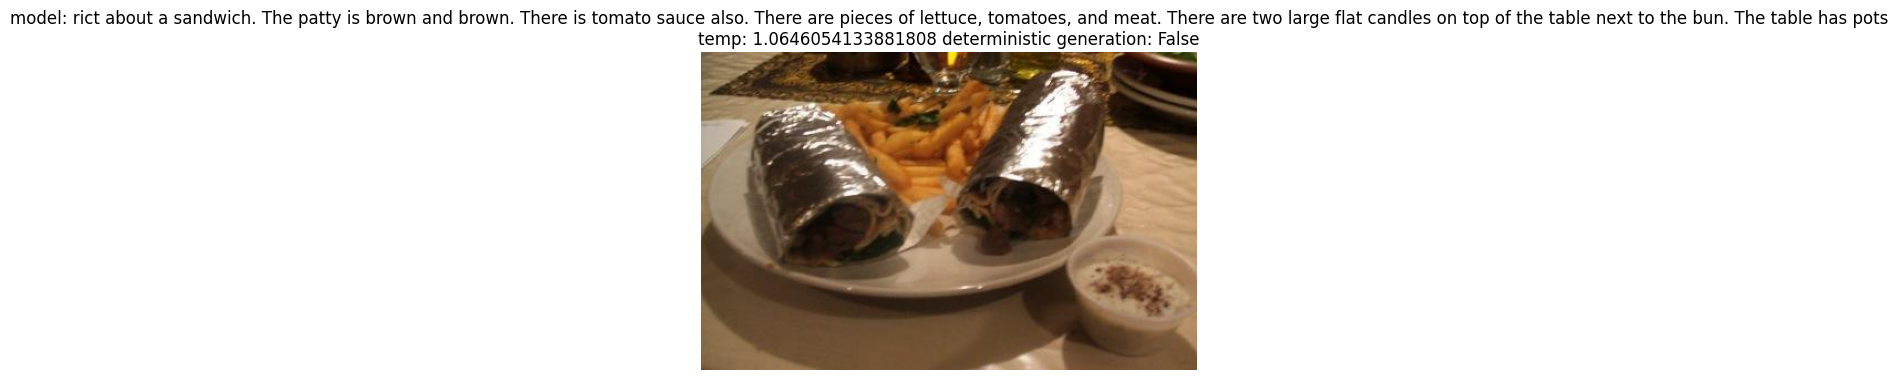

In [ ]:
test_img=r"/content/drive/MyDrive/Colab Notebooks/Data/IC_dataset/train/train_1.jpg"
# test_caption="A white round plate is on a table with a plastic tablecloth on it.  Two foil covered food halves are on the white plate along with a serving of golden yellow french fries.  Next to the white plate in a short,  topless, plastic container is a white sauce.  Diagonal to the white plate are the edges of several other stacked plates.  There are black shadows reflected on the table."
for i in range(1):
    det = False
    # test = val_df.sample(n=1).values[0]
    # test_img, test_caption = test[0],test[1]
    plt.imshow(Image.open(test_img).convert('RGB'))
    t = np.random.uniform(0.5,1.5)
    if i > 40:
        det = True
    gen_caption = generate_caption(test_img,temperature=t,deterministic=det)
    plt.title(f"model: {gen_caption}\ntemp: {t} deterministic generation: {det}")
    plt.axis('off')
    plt.show()